In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

In [10]:
def laplacian_pyramid(image, levels=4):
    pyramid = [image]
    for _ in range(levels):
        downsampled_image = cv2.pyrDown(image)
        expanded = cv2.pyrUp(downsampled_image)
        diff = cv2.subtract(pyramid[-1], expanded)
        pyramid.append(diff)
    return pyramid


In [56]:
def create_gaussian_mask(image_shape, level):
    # Calculate the size of the Gaussian kernel based on the level
    #kernel_size = (2**level) * 2 + 1  # Ensuring the kernel size is always odd

    # Create the Gaussian mask
    #mask = cv2.GaussianBlur(np.zeros(image_shape, dtype=np.float32), (kernel_size, kernel_size), 0)

    # Create a Gaussian kernel with appropriate size
    kernel_size = (2 ** level) * 2 + 1  # Ensure kernel size is odd
    gaussian_kernel = cv2.getGaussianKernel(kernel_size, -1)

    # Create a 2D Gaussian mask by multiplying the kernel with its transpose
    gaussian_mask = np.outer(gaussian_kernel, gaussian_kernel.transpose())

    # Normalize the mask
    gaussian_mask /= np.max(gaussian_mask)

    # Resize the mask to match the size of the image
    gaussian_mask_resized = cv2.resize(gaussian_mask, (image_shape[1], image_shape[0]))

    return gaussian_mask_resized
    return mask

In [22]:
def plot_images(modified_images):
  num_components = len(modified_images)

  fig, axes = plt.subplots(2, 2, figsize=(10.5, 10.5))
  k = num_components - 1
  n_rows = num_components // 2

  for r in range(n_rows):
    for c in range(2):
      img = modified_images[k]
      img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      axes[r, c].imshow(img_rgb)
      title_text = f'Image {num_components - k -1}'
      axes[r, c].set_title(title_text)
      axes[r, c].axis('off')
      k -= 1

  plt.suptitle('Laplacian Pyramid', fontsize=16)
  plt.tight_layout()
  plt.axis('off')
  plt.show()

In [24]:
def deblend_images(image, levels=4):
    # Step 1: Decompose the image into its Laplacian pyramid
    laplacian_pyr = laplacian_pyramid(image, levels)
    plot_images(laplacian_pyr)

    # Initialize a list to store the modified Laplacian pyramids
    modified_pyr = []

    # Step 2: Create Gaussian masks for each level of the Laplacian pyramid
    masks = [create_gaussian_mask(laplacian_pyr[i].shape[:2], i) for i in range(levels)]

    # Step 3: Multiply each level of the Laplacian pyramid with its corresponding Gaussian mask
    for i in range(levels):
        modified_pyr.append(laplacian_pyr[i] * masks[i][:, :, np.newaxis])

    plot_images(modified_pyr)
    # Step 4: Reconstruct the individual images
    images = [modified_pyr[i] + modified_pyr[i+1] for i in range(levels-1)]
    images.append(modified_pyr[-1])

    plot_images(images)

    # Reconstruct the original image from the modified pyramid
    reconstructed_image = images[-1]
    for i in range(levels-2, -1, -1):
        reconstructed_image = cv2.pyrUp(reconstructed_image)
        reconstructed_image += images[i]

    # Normalize the reconstructed image
    reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)

    return reconstructed_image

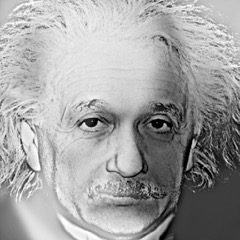

In [35]:
# Load the image
einsteinandwho = cv2.imread('einsteinandwho.jpeg')
cv2_imshow(einsteinandwho)

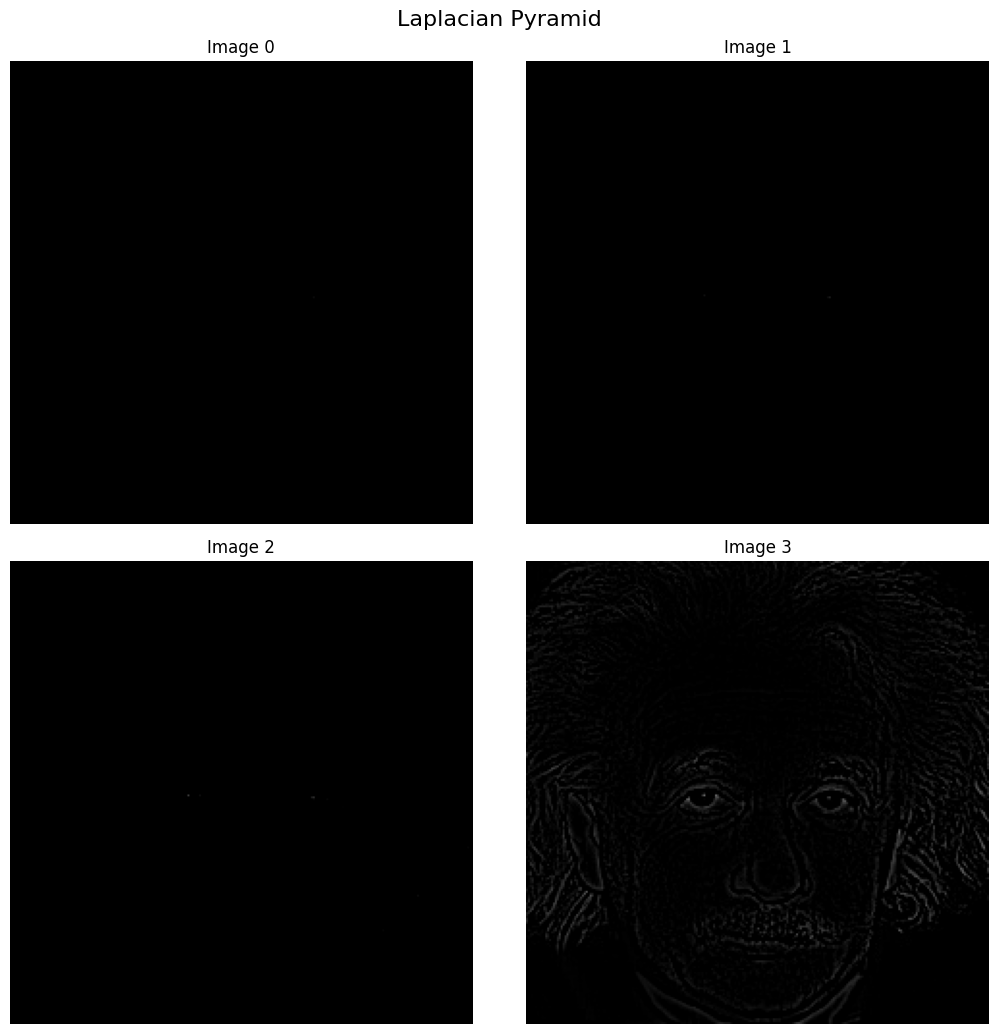

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


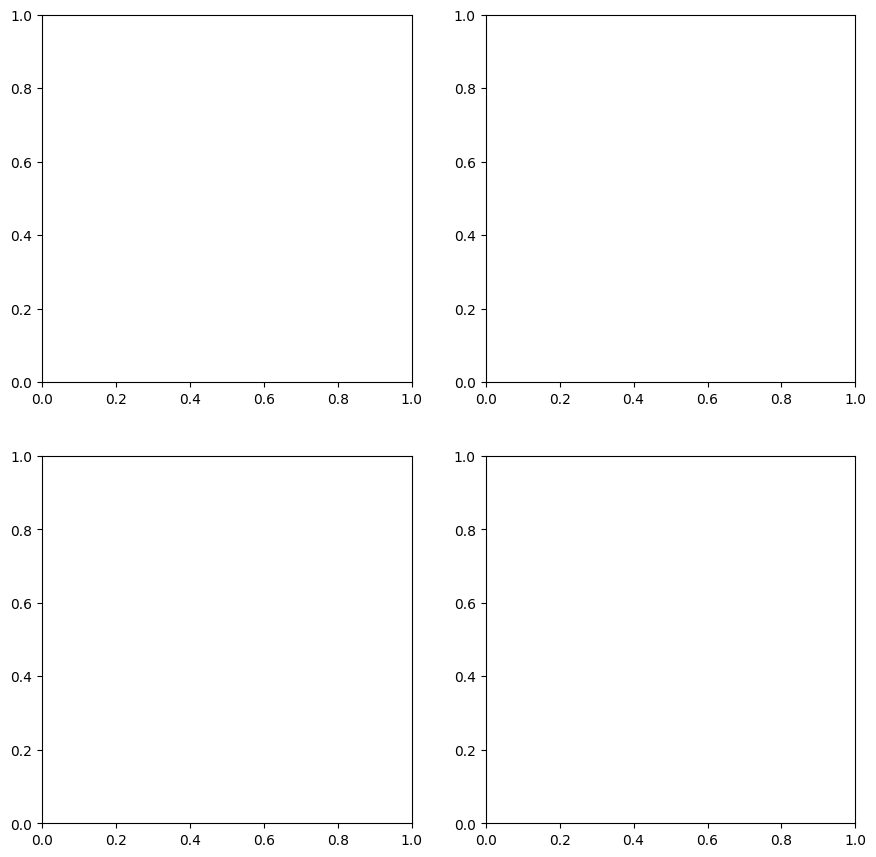

In [57]:
# De-blend the image into two images
deblended_image = deblend_images(einsteinandwho)

In [ ]:
cv2_imshow(deblended_image)

In [36]:
def intensityscale(raw_img):
    # scale an image's intensity from [min, max] to [0, 1].
    v_min, v_max = raw_img.min(), raw_img.max()
    scaled_im = (raw_img * 1.0 - v_min) / (v_max - v_min)
    # keep the mean to be 0.5.
    meangray = np.mean(scaled_im)
    scaled_im = scaled_im - meangray + 0.5
    # clip to [0, 1]\n",
    return np.clip(scaled_im, 0, 1)

In [37]:
im_scaled = intensityscale(einsteinandwho)

In [38]:
blur = cv2.GaussianBlur(einsteinandwho,(7,7),sigmaX=5, sigmaY=5) # low pass
einstein = im_scaled-blur  #high pass => einstein

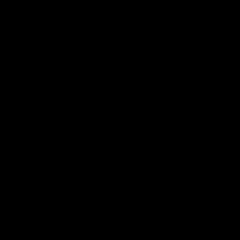

In [39]:
cv2_imshow(einstein)

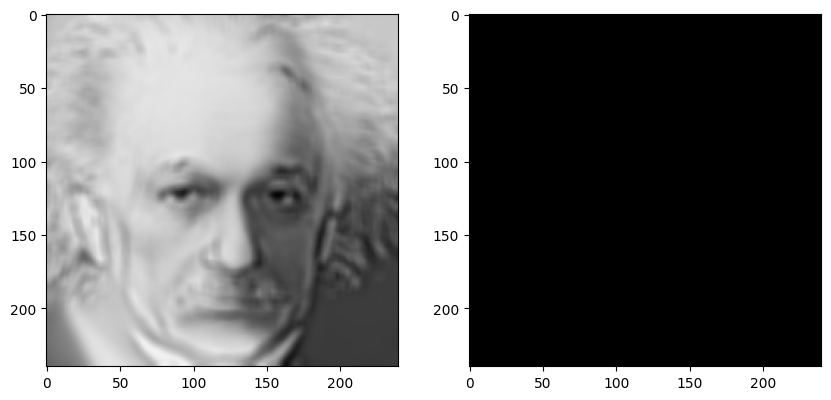

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(blur, cmap=plt.cm.gray)
axes[1].imshow(einstein, cmap=plt.cm.gray)

In [42]:
einstein

array([[[-184.44391776, -184.44391776, -184.44391776],
        [-184.42823148, -184.42823148, -184.42823148],
        [-185.41254521, -185.41254521, -185.41254521],
        ...,
        [-197.36156481, -197.36156481, -197.36156481],
        [-196.36156481, -196.36156481, -196.36156481],
        [-196.36548638, -196.36548638, -196.36548638]],

       [[-184.43607462, -184.43607462, -184.43607462],
        [-184.42038834, -184.42038834, -184.42038834],
        [-185.40862364, -185.40862364, -185.40862364],
        ...,
        [-197.36156481, -197.36156481, -197.36156481],
        [-197.36156481, -197.36156481, -197.36156481],
        [-196.36156481, -196.36156481, -196.36156481]],

       [[-184.42823148, -184.42823148, -184.42823148],
        [-184.41254521, -184.41254521, -184.41254521],
        [-185.4007805 , -185.4007805 , -185.4007805 ],
        ...,
        [-197.35764325, -197.35764325, -197.35764325],
        [-197.36156481, -197.36156481, -197.36156481],
        [-197.36156481

array([[[185, 185, 185],
        [185, 185, 185],
        [186, 186, 186],
        ...,
        [198, 198, 198],
        [197, 197, 197],
        [197, 197, 197]],

       [[185, 185, 185],
        [185, 185, 185],
        [186, 186, 186],
        ...,
        [198, 198, 198],
        [198, 198, 198],
        [197, 197, 197]],

       [[185, 185, 185],
        [185, 185, 185],
        [186, 186, 186],
        ...,
        [198, 198, 198],
        [198, 198, 198],
        [198, 198, 198]],

       ...,

       [[103, 103, 103],
        [103, 103, 103],
        [104, 104, 104],
        ...,
        [ 59,  59,  59],
        [ 59,  59,  59],
        [ 59,  59,  59]],

       [[102, 102, 102],
        [103, 103, 103],
        [103, 103, 103],
        ...,
        [ 59,  59,  59],
        [ 59,  59,  59],
        [ 59,  59,  59]],

       [[102, 102, 102],
        [102, 102, 102],
        [103, 103, 103],
        ...,
        [ 59,  59,  59],
        [ 59,  59,  59],
        [ 59,  59,  59]]], dtype=uint8)
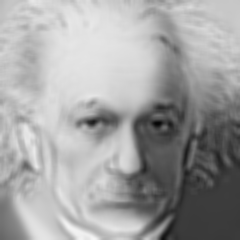

In [43]:
blur

In [45]:
laplacian = cv2.Laplacian(einsteinandwho, cv2.CV_32F)

# High-pass filter: Subtract blurred image from original
high_pass_filtered = einsteinandwho - blur

array([[[247, 247, 247],
        [251, 251, 251],
        [254, 254, 254],
        ...,
        [255, 255, 255],
        [  0,   0,   0],
        [255, 255, 255]],

       [[249, 249, 249],
        [253, 253, 253],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [  0,   0,   0]],

       [[251, 251, 251],
        [255, 255, 255],
        [  1,   1,   1],
        ...,
        [  0,   0,   0],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[252, 252, 252],
        [255, 255, 255],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[251, 251, 251],
        [254, 254, 254],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[250, 250, 250],
        [254, 254, 254],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]], dtype=uint8)
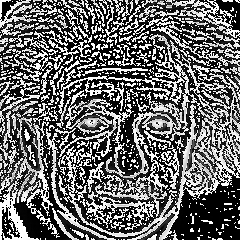

In [46]:
high_pass_filtered

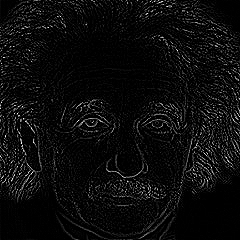

In [48]:
cv2_imshow(laplacian)

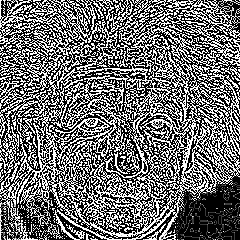

In [55]:
cv2_imshow(blur * laplacian)